%%latex
\tableofcontents

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
import random
import csv
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor 
import matplotlib.cm as cm

# Introduction

We have trained model which is succesful in the C2P conversion, and this neural network is called NNC2Pv0. Naturally, we want to improve on these methods. One possibility is pruning the neural network: if we have less connections and neurons, we are more likely 

# Generating training data

In [ ]:
# Define the three functions determining the output
def eos(rho, eps, Gamma = 5/3):
    """Computes the analytical gamma law EOS from rho and epsilon"""
    return (Gamma - 1) * rho * eps

def h(rho, eps, v):
    """Enthalpy"""
    p = eos(rho, eps)
    return 1 + eps + p/rho

def W(rho, eps, v):
    """Lorentz factor. Here, in 1D so v = v_x"""
    return (1-v**2)**(-1/2)

def D(rho, eps, v):
    """See eq 2 paper"""
    return rho*W(rho, eps, v)

def S(rho, eps, v):
    """See eq2 paper. Note: 1D only for now."""
    return rho*h(rho, eps, v)*((W(rho, eps, v))**2)*v

def tau(rho, eps, v):
    """See eq2 paper."""
    return rho*(h(rho, eps, v))*((W(rho, eps, v))**2) - eos(rho, eps) - D(rho, eps, v)

We generate data as follows. We create a training set by randomly sampling as follows:
- $\rho \in (0, 10.1)$,
- $\epsilon \in (0, 2.02)$, 
- $v_x \in (0, 0.721)$.

In [ ]:
# Define ranges of parameters to be sampled (see paper Section 2.1)
rho_min = 0
rho_max = 10.1
eps_min = 0
eps_max = 2.02
v_min = 0
v_max = 0.721

Note: the code in comment below was used to generate the data. It has now been saved separately in a folder called "data".

In [ ]:
# number_of_datapoints = 10000
# data = []

# for i in range(number_of_datapoints):
#     rho = random.uniform(rho_min, rho_max)
#     eps = random.uniform(eps_min, eps_max)
#     v     = random.uniform(v_min, v_max)
    
#     p               = eos(rho, eps)
#     Dvalue    = D(rho, eps, v)
#     Svalue     = S(rho, eps, v)
#     tauvalue = tau(rho, eps, v)
    
#     new_row = [rho, eps, v, p, Dvalue, Svalue, tauvalue]
    
#     data.append(new_row)

Save the data in a csv file:

In [ ]:
# header = ['rho', 'eps', 'v', 'p', 'D', 'S', 'tau']

# with open('data/NNC2P_data_test.csv', 'w', newline = '') as file:
#     writer = csv.writer(file)
#     # write header
#     writer.writerow(header)
#     # write data
#     writer.writerows(data)

In [ ]:
# Import data
data_train = pd.read_csv("data/NNC2P_data_train.csv")
data_test = pd.read_csv("data/NNC2P_data_test.csv")
print("The training data has " + str(len(data_train)) + " instances")
print("The test data has " + str(len(data_test)) + " instances")
data_train

# Getting data into PyTorch's DataLoader

Below: `all_data` is of the type $(\rho, \epsilon, v, p, D, S_x, \tau)$ as generated above.

In [7]:
class CustomDataset(Dataset):
    """See PyTorch tutorial: the following three methods HAVE to be implemented"""
    
    def __init__(self, all_data, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        
        # Separate features (rho and eps) from the labels (p, chi, kappa)
        # (see above to get how data is organized)
        features = []
        labels = []
        
        for i in range(len(all_data)):
            # Separate the features
            new_feature = [all_data['D'][i], all_data['S'][i], all_data['tau'][i]]
            features.append(torch.tensor(new_feature, dtype = torch.float32))
            # Separate the labels
            #new_label = [all_data['rho'][i], all_data['eps'][i], all_data['v'][i], all_data['p'][i]]
            new_label = all_data['p'][i]
            labels.append(torch.tensor(new_label, dtype = torch.float32))
            
        # Save as instance variables to the dataloader
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        feature = self.features[idx]
        if self.transform:
            feature = transform(feature)
        label = self.labels[idx]
        if self.target_transform:
            feature = target_transform(label)
            
        return feature, label

Note that the following cell may be confusing. "data_train" refers to the data that was generatd above, see the pandas table. "training_data" is defined similarly as in the PyTorch tutorial, see [this page](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) and this is an instance of the class CustomDataset defined above.

In [8]:
# Make training and test data, as in the tutorial
training_data = CustomDataset(data_train)
test_data = CustomDataset(data_test)

In [9]:
# Check if this is done correctly
print(training_data.features[:3])
print(training_data.labels[:3])

[tensor([0.6794, 0.1737, 0.0773]), tensor([11.3668, 13.3185,  7.7181]), tensor([4.3881, 0.3473, 7.0206])]
[tensor(0.0372), tensor(1.1761), tensor(4.6761)]


In [10]:
# Now call DataLoader on the above CustomDataset instances:
train_dataloader = DataLoader(training_data, batch_size=32)
test_dataloader = DataLoader(test_data, batch_size=32)

# Building the neural networks

We will follow [this part of the PyTorch tutorial](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html). For more information, see the [documentation page of torch.nn](https://pytorch.org/docs/stable/nn.html). We take the parameters of NNEOS

In [11]:
# Define hyperparameters of the model here. Will first of all put two hidden layers
# total of 800 neurons for the one in the paper
device = "cpu"
size_HL_1 = 600
size_HL_2 = 200

# Implement neural network
class NeuralNetwork(nn.Module):
    def __init__(self, size_HL_1=600, size_HL_2=200):
        super(NeuralNetwork, self).__init__()
        #self.flatten = nn.Flatten()
        self.stack = nn.Sequential(
            nn.Linear(3, size_HL_1),
            nn.Sigmoid(),
            nn.Linear(size_HL_1, size_HL_2),
            nn.Sigmoid(),
            nn.Linear(size_HL_2, 1)
        )

    def forward(self, x):
        # No flatten needed, as our input and output are 1D?
        #x = self.flatten(x) 
        logits = self.stack(x)
        return logits

In [12]:
# test
test_model = NeuralNetwork(100,100).to(device)
print(test_model)

NeuralNetwork(
  (stack): Sequential(
    (0): Linear(in_features=3, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=1, bias=True)
  )
)


# Training the neural network

We added a regularization term, with a coefficient specified by $\lambda$ ([source](https://androidkt.com/how-to-add-l1-l2-regularization-in-pytorch-loss-function/)).

In [13]:
def compute_loss(pred, y, regularization=False, l1_lambda = 0.001, verbose=False):
    """Adds a regularization term on top of the used loss function.
        Note: Replace abs() with pow(2.0) for L2 regularization"""
    
    # use the specified loss function
    loss = loss_fn(pred, y)
        
    # If we use regularization:
    if regularization:
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += l1_lambda * l1_norm
            
    return loss

In [14]:
def train_loop(dataloader, model, loss_fn, optimizer, report_progress=False, regularization=False):
    """The training loop of the algorithm"""
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = compute_loss(pred, y,regularization)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # If we want to report progress during training (not recommended - obstructs view)
        if report_progress:
            if batch % 100 == 0:
                loss, current = loss.item(), batch * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, regularization=False):
    """The testing loop of the algorithm"""
    num_batches = len(dataloader)
    test_loss = 0

    # Predict and compute losses
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += compute_loss(pred, y, regularization).item()
            
    average_test_loss = test_loss/num_batches
    return average_test_loss

Now we generate an instance of the above neural network in `model` (note: running this cell will create a 'fresh' model!).

Save hyperparameters and loss function - note that we follow the paper. I think that their loss function agrees with [MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss). The paper uses the [Adam optimizer](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam). More details on optimizers can be found [here](https://pytorch.org/docs/stable/optim.html). Required argument `params` can be filled in by calling `model` which contains the neural network. For simplicity we will train for 10 epochs here.

In [15]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (stack): Sequential(
    (0): Linear(in_features=3, out_features=600, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=600, out_features=200, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=200, out_features=1, bias=True)
  )
)


In [16]:
for name, param in model.state_dict().items():
    print("---")
    print(name)
    print(np.shape(param))

---
stack.0.weight
torch.Size([600, 3])
---
stack.0.bias
torch.Size([600])
---
stack.2.weight
torch.Size([200, 600])
---
stack.2.bias
torch.Size([200])
---
stack.4.weight
torch.Size([1, 200])
---
stack.4.bias
torch.Size([1])


In [17]:
previous_model = torch.load("Models/NNC2Pv0t2.pth")

In [18]:
state_dict = previous_model.state_dict()
state_dict_items = state_dict.items()

In [19]:
for name, item in previous_model.state_dict().items():
    print("---")
    if name == "stack.2.weight":
        print("Saving example")
        example_matrix = item
    if name == "stack.2.bias":
        print("Saving example")
        example_vector = item
    print(name)
    print(np.shape(item))

---
stack.0.weight
torch.Size([600, 3])
---
stack.0.bias
torch.Size([600])
---
Saving example
stack.2.weight
torch.Size([200, 600])
---
Saving example
stack.2.bias
torch.Size([200])
---
stack.4.weight
torch.Size([1, 200])
---
stack.4.bias
torch.Size([1])


In [20]:
def delete_column_tensor(x, index):
    """x is a torch tensor with shape (n, m). Returns tensor with shape (n, m-1) and deletes the column at specified index."""
    
    # Delete the column by splitting into two pieces, transpose the tensors for cat
    a = torch.transpose(x[:, :index], 0, 1)
    b = torch.transpose(x[:, index+1:], 0, 1)
    
    # Concatenate the two results, with the desired column deleted
    new = torch.cat((a, b))
    
    return torch.transpose(new, 0, 1)

In [21]:
def delete_row_tensor(x, index):
    """x is a torch tensor with shape (n, m). Returns tensor with shape (n, m-1) and deletes the column at specified index."""
    
    # Delete the column by splitting into two pieces, transpose the tensors for cat
    a = x[:index]
    b = x[index+1:]
    
    # Return concatenation    
    return torch.cat((a, b))

In [22]:
# print(example_matrix)
# print(np.shape(example_matrix))
# print("---")
# new = delete_column_tensor(example_matrix, 1)
# print(new)
# print(np.shape(new))
# print("---")
# new = delete_row_tensor(example_matrix, 1)
# print(new)
# print(np.shape(new))

In [23]:
# print(example_vector)
# print(np.shape(example_vector))
# print("---")
# new = delete_row_tensor(example_vector, 1)
# print(new)
# print(np.shape(new))

## Pruning methods

In [24]:
def prune_nn_once(old_model):
    
    # Get the relevant info
    state_dict             = old_model.state_dict()
    state_dict_items = state_dict.items()
    
    # Get number of layers:
    number_of_layers = len(state_dict_items)//2
    
    # Get number of neurons in each layer (hidden + output, not input)
    number_neurons = np.array([0 for i in range(number_of_layers)])
    counter = 0
    for name, item in state_dict_items:
        if "weight" in name:
            number_neurons[counter] = np.shape(item)[0]
            counter += 1
    number_neurons_hidden = number_neurons[:-1]
    
    # Get probabilities based on this:
    probabilities_hidden_layers = number_neurons_hidden/np.sum(number_neurons_hidden)
    
    # Get the hidden layer from which we are going to prune:
    layer_index     = np.random.choice(number_of_layers-1, p=probabilities_hidden_layers)
    # Get the index of the neuron we are going to delete in this layer (uniform probability)
    neuron_index = np.random.choice(number_neurons_hidden[layer_index])
    
    # Also get layer index: they have increments of two
    layer_number = 2*layer_index + 2
    # Testing
#     print(layer_index)
#     print(neuron_index)
#     print(layer_number)
    
    # Copy the state dict of original model
    new_state_dict = state_dict.copy()
    
    # Prune that state dict:
    for key in new_state_dict:
        # Prune previous (increment -2!) weight matrix by deleting the row:
        if  str(layer_number - 2) + ".weight" in key:
            old = new_state_dict[key]
            new = delete_row_tensor(old, neuron_index)
            new_state_dict[key] = new
            
        # Prune current weight matrix by deleting the column
        if  str(layer_number) + ".weight" in key:
            old = new_state_dict[key]
            new = delete_column_tensor(old, neuron_index)
            new_state_dict[key] = new
            
        # Prune the current bias vector by deleting the row:
        if  str(layer_number-2) + ".bias" in key:
            old = new_state_dict[key]
            new = delete_row_tensor(old, neuron_index)
            new_state_dict[key] = new        
        
    # Instantiate a new model, with the appropriate number of hidden neurons, and save the pruned state dict
    new_number_neurons_hidden = number_neurons_hidden
    new_number_neurons_hidden[layer_index] -= 1
    new_model = NeuralNetwork(new_number_neurons_hidden[0], new_number_neurons_hidden[1]).to(device)
    new_model.load_state_dict(new_state_dict)
    
    return new_model

In [25]:
def prune_nn(old_model, number=10):
    counter = 0
    while counter < number:
        new_model = prune_nn_once(old_model)
        old_model = new_model
        counter +=1
    return new_model

In [26]:
new_model = prune_nn(previous_model)

__Training:__

In [180]:
print(model)

# Save hyperparameters, loss function and optimizer here (see paper for details)
learning_rate = 6e-3
batch_size = 32
adaptation_threshold = 0.9995
adaptation_multiplier = 0.5

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

NeuralNetwork(
  (stack): Sequential(
    (0): Linear(in_features=3, out_features=600, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=600, out_features=200, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=200, out_features=1, bias=True)
  )
)


In [47]:
# Restart training by changing this parameter:
restart = True
abort = False
max_number_epochs = 1200

# Initialize lists in case we start a new training loop
if restart:
    confirmation = input("Are you sure you want to restart? Press y >> ")
    if confirmation == "y":
        # Empty the arrays
        test_losses = []
        train_losses = []
        train_losses_subset = []
        adaptation_indices = []
        counter = -5 # we skip the very first few iterations before changing learning rate
    else:
        print("Aborting training.")
        abort = True

# Acutal training loop is done:
if abort is False:
    epoch_counter = len(train_losses) + 1

    print("Training the model . . .")
    if restart is False:
        print("(Continued)")
        
    # Training: 
    while epoch_counter < max_number_epochs:
        print(f"\n Epoch {epoch_counter} \n --------------")
        # Train 
        train_loop(train_dataloader, model, loss_fn, optimizer)
        # Test on the training data
        average_train_loss = test_loop(train_dataloader, model, loss_fn)
        train_losses.append(average_train_loss)
        # Test on testing data
        average_test_loss = test_loop(test_dataloader, model, loss_fn)
        test_losses.append(average_test_loss)

        # Update the learning rate - see Appendix B of the paper
        # only check if update needed after 10 new epochs
        if counter >= 10:
            current = np.min(train_losses[-5:])
            previous = np.min(train_losses[-10:-5])

            # If we did not improve the test loss sufficiently, going to adapt LR
            if current/previous >= adaptation_threshold:
                # Reset counter (note: will increment later, so set to -1 st it becomes 0)
                counter = -1
                learning_rate = adaptation_multiplier*learning_rate
                print(f"Adapting learning rate to {learning_rate}")
                # Change optimizer
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                # Add the epoch time for plotting later on
                adaptation_indices.append(epoch_counter)

        # Report progress:
#         print(f"Average loss of: {average_test_loss} for test data")
        print(f"Average loss of: {average_train_loss} for train data")
        
        # Another epoch passed - increment counter
        counter += 1
        epoch_counter += 1

    print("Done!")

Are you sure you want to restart? Press y >> y
Training the model . . .

 Epoch 1 
 --------------
Average loss of: 0.00872820215318352 for train data

 Epoch 2 
 --------------
Average loss of: 0.007063842177391052 for train data

 Epoch 3 
 --------------
Average loss of: 0.00637879533469677 for train data

 Epoch 4 
 --------------
Average loss of: 0.00600121963750571 for train data

 Epoch 5 
 --------------
Average loss of: 0.002137273640325293 for train data

 Epoch 6 
 --------------
Average loss of: 0.001179007091803942 for train data

 Epoch 7 
 --------------
Average loss of: 0.01587883297232911 for train data

 Epoch 8 
 --------------
Average loss of: 0.0009293159693130291 for train data

 Epoch 9 
 --------------
Average loss of: 0.002137645937129855 for train data

 Epoch 10 
 --------------
Average loss of: 0.0010697434115107172 for train data

 Epoch 11 
 --------------
Average loss of: 0.0012809499812545255 for train data

 Epoch 12 
 --------------
Average loss of: 0.

Average loss of: 4.726605654832383e-05 for train data

 Epoch 99 
 --------------
Average loss of: 4.6690779056189055e-05 for train data

 Epoch 100 
 --------------
Average loss of: 4.6521267741627525e-05 for train data

 Epoch 101 
 --------------
Average loss of: 4.6325746760885524e-05 for train data

 Epoch 102 
 --------------
Average loss of: 4.628524026829837e-05 for train data

 Epoch 103 
 --------------
Average loss of: 4.6133683936750455e-05 for train data

 Epoch 104 
 --------------
Average loss of: 4.5974988965645024e-05 for train data

 Epoch 105 
 --------------
Average loss of: 4.579538890375261e-05 for train data

 Epoch 106 
 --------------
Average loss of: 4.561426963919075e-05 for train data

 Epoch 107 
 --------------
Average loss of: 4.544417599445296e-05 for train data

 Epoch 108 
 --------------
Average loss of: 4.528103824122809e-05 for train data

 Epoch 109 
 --------------
Average loss of: 4.512432956089469e-05 for train data

 Epoch 110 
 --------------


Average loss of: 3.8301719641276574e-05 for train data

 Epoch 198 
 --------------
Average loss of: 3.821907075925992e-05 for train data

 Epoch 199 
 --------------
Average loss of: 3.820299303697539e-05 for train data

 Epoch 200 
 --------------
Average loss of: 3.8055111950961875e-05 for train data

 Epoch 201 
 --------------
Average loss of: 3.808664730422606e-05 for train data

 Epoch 202 
 --------------
Average loss of: 3.797454018276767e-05 for train data

 Epoch 203 
 --------------
Average loss of: 3.796052513134782e-05 for train data

 Epoch 204 
 --------------
Average loss of: 3.788569895114051e-05 for train data

 Epoch 205 
 --------------
Average loss of: 3.782982475058816e-05 for train data

 Epoch 206 
 --------------
Average loss of: 3.77691244109883e-05 for train data

 Epoch 207 
 --------------
Average loss of: 3.7708422615651213e-05 for train data

 Epoch 208 
 --------------
Average loss of: 3.7647519157508216e-05 for train data

 Epoch 209 
 --------------
A

Average loss of: 2.408218313657926e-05 for train data

 Epoch 296 
 --------------
Average loss of: 2.403518391279249e-05 for train data

 Epoch 297 
 --------------
Average loss of: 2.398535204924883e-05 for train data

 Epoch 298 
 --------------
Average loss of: 2.393869577699661e-05 for train data

 Epoch 299 
 --------------
Average loss of: 2.3887062521225742e-05 for train data

 Epoch 300 
 --------------
Average loss of: 2.3840319645523777e-05 for train data

 Epoch 301 
 --------------
Average loss of: 2.3793173907415623e-05 for train data

 Epoch 302 
 --------------
Average loss of: 2.3750755834680605e-05 for train data

 Epoch 303 
 --------------
Average loss of: 2.3710838874922046e-05 for train data

 Epoch 304 
 --------------
Average loss of: 2.3663316328747898e-05 for train data

 Epoch 305 
 --------------
Average loss of: 2.3622931768522902e-05 for train data

 Epoch 306 
 --------------
Average loss of: 2.3558367411533256e-05 for train data

 Epoch 307 
 -----------

Average loss of: 2.088258677099475e-05 for train data

 Epoch 394 
 --------------
Average loss of: 2.085752125472027e-05 for train data

 Epoch 395 
 --------------
Average loss of: 2.08326202425269e-05 for train data

 Epoch 396 
 --------------
Average loss of: 2.0807341872705366e-05 for train data

 Epoch 397 
 --------------
Average loss of: 2.0782681981563655e-05 for train data

 Epoch 398 
 --------------
Average loss of: 2.0757478513587557e-05 for train data

 Epoch 399 
 --------------
Average loss of: 2.0732007422884634e-05 for train data

 Epoch 400 
 --------------
Average loss of: 2.0707543704611454e-05 for train data

 Epoch 401 
 --------------
Average loss of: 2.0682218356250815e-05 for train data

 Epoch 402 
 --------------
Average loss of: 2.0657560455038036e-05 for train data

 Epoch 403 
 --------------
Average loss of: 2.0633117477746054e-05 for train data

 Epoch 404 
 --------------
Average loss of: 2.060889978306477e-05 for train data

 Epoch 405 
 ------------

Average loss of: 1.8856752592137126e-05 for train data

 Epoch 492 
 --------------
Average loss of: 1.883958273697317e-05 for train data

 Epoch 493 
 --------------
Average loss of: 1.8822280438325835e-05 for train data

 Epoch 494 
 --------------
Average loss of: 1.880481401249199e-05 for train data

 Epoch 495 
 --------------
Average loss of: 1.8787474440887308e-05 for train data

 Epoch 496 
 --------------
Average loss of: 1.877053421389974e-05 for train data

 Epoch 497 
 --------------
Average loss of: 1.8753105048654107e-05 for train data

 Epoch 498 
 --------------
Average loss of: 1.8736298746716786e-05 for train data

 Epoch 499 
 --------------
Average loss of: 1.8718998030271907e-05 for train data

 Epoch 500 
 --------------
Average loss of: 1.8702340095296677e-05 for train data

 Epoch 501 
 --------------
Average loss of: 1.868569274688525e-05 for train data

 Epoch 502 
 --------------
Average loss of: 1.8668727300519094e-05 for train data

 Epoch 503 
 -----------

Average loss of: 1.7417177801507932e-05 for train data

 Epoch 591 
 --------------
Average loss of: 1.7404935236299935e-05 for train data

 Epoch 592 
 --------------
Average loss of: 1.7392070729601984e-05 for train data

 Epoch 593 
 --------------
Average loss of: 1.7380145124479897e-05 for train data

 Epoch 594 
 --------------
Average loss of: 1.736791373896267e-05 for train data

 Epoch 595 
 --------------
Average loss of: 1.735608732797118e-05 for train data

 Epoch 596 
 --------------
Average loss of: 1.734394449231331e-05 for train data

 Epoch 597 
 --------------
Average loss of: 1.733173592770072e-05 for train data

 Epoch 598 
 --------------
Average loss of: 1.7320078268176076e-05 for train data

 Epoch 599 
 --------------
Average loss of: 1.7307650479415315e-05 for train data

 Epoch 600 
 --------------
Average loss of: 1.7296503500438122e-05 for train data

 Epoch 601 
 --------------
Average loss of: 1.728539226196517e-05 for train data

 Epoch 602 
 ------------

KeyboardInterrupt: 

## Results of training

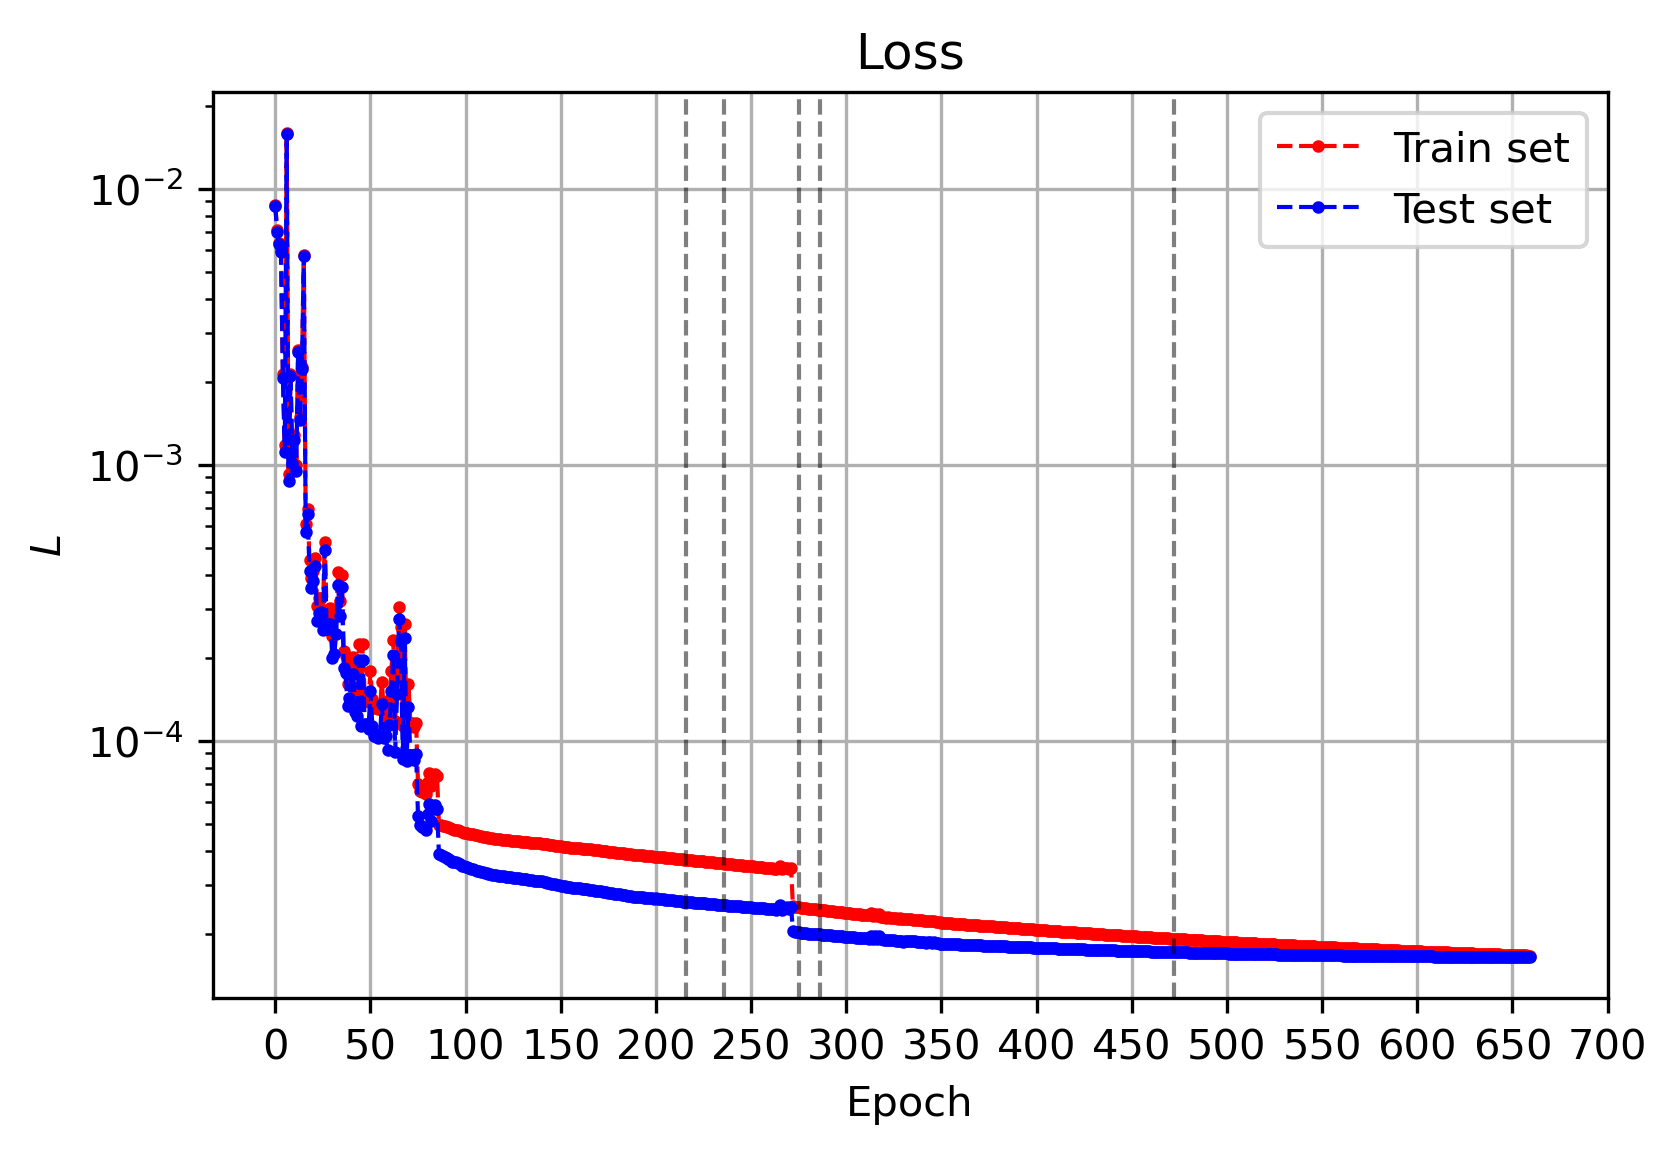

In [48]:
# Plot it
plt.figure()
lw = 1
ms = 2
plt.plot(train_losses, 'o--', color = 'red', label = 'Train set', lw = lw, ms = ms)
plt.plot(test_losses, 'o--', color = 'blue', label = "Test set", lw = lw, ms = ms)
plt.legend()
plt.grid()
plt.xlabel("Epoch")
xt_step = 50
xt = [i*xt_step for i in range(len(train_losses)//xt_step+2)]
plt.xticks(xt)
plt.ylabel(r'$L$')
plt.axhline(0, color = 'black', alpha = 0.7)
plt.title("Loss")
# Plot when we adapted learning rate
for t in adaptation_indices:
    plt.axvline(t+200, linestyle = "--", color = 'black', alpha = 0.5, lw = 1)
plt.yscale('log')
# plt.ylim(10**(-9))
# plt.savefig("Plots/NNC2Pv1.pdf", bbox_inches = 'tight')
plt.show()

In [27]:
# torch.save(model, 'Models/NNC2Pv1.pth')

# Analyzing neural networks

We import NNC2Pv0, which beats the performance of the models in the paper.

In [28]:
NNC2P = torch.load('Models/NNC2Pv0t2.pth')

## Estimate the performance of the network

In [29]:
def L1_norm(predictions, y):
    """Here, predictions and y are arrays for one specific quantity, eg pressure. See table 1"""
    return np.sum(abs(predictions - y))/len(predictions)

In [30]:
def Linfty_norm(predictions, y):
    """Here, predictions and y are arrays for one specific quantity, eg pressure. See table 1"""
    return max(abs(predictions - y))

In [31]:
# Get features and labels
test_features = test_data.features
test_labels = test_data.labels
test_features[:4]

[tensor([10.2041, 12.0266, 22.1313]),
 tensor([ 7.0046, 22.3374, 21.0772]),
 tensor([ 9.5747, 10.5188, 10.0152]),
 tensor([0.7725, 1.8519, 1.8100])]

In [32]:
test_features[0]

tensor([10.2041, 12.0266, 22.1313])

##### What is the performance of a randomly pruned NN?

In [35]:
number = 20
new_model = prune_nn(NNC2P, number=number)
model = new_model
models = [NNC2P, new_model]
names = ["NNC2P", "pruned"]

for i in range(len(models)):
    # Get model and name
    model = models[i]
    name = names[i]

    # Get predictions
    with torch.no_grad():
        p_hat= np.array([])
        for input_values in test_features:
            prediction = model(input_values)
            p_hat = np.append(p_hat, prediction[0].item())

    # Get labels as np arrays
    p = np.array([])
    for value in test_labels:
        p = np.append(p, value.item())

    # Get the errors:
    delta_p_L1       = L1_norm(p_hat, p)
    delta_p_Linfty = Linfty_norm(p_hat, p)

    print("Errors for p: %e  with L1 and %e with Linfty for %s with %d neurons pruned" % (delta_p_L1, delta_p_Linfty, name, number) )

Errors for p: 2.623259e-04  with L1 and 8.344986e-03 with Linfty for NNC2P with 20 neurons pruned
Errors for p: 2.649312e-01  with L1 and 1.045513e+00 with Linfty for pruned with 20 neurons pruned
